In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
from tqdm import tqdm

2024-07-20 14:48:48.248097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 14:48:48.409658: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 14:48:48.571341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 14:48:48.712123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 14:48:48.749119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 14:48:51.223407: W tensorflow/compiler/tf2tensorrt/utils/p

### Read Data 

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object



In [3]:
train = get_training_data('chest_xray/chest_xray/train')
test = get_training_data('chest_xray/chest_xray/test')
val = get_training_data('chest_xray/chest_xray/val')

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 195.88it/s]


### Samples about data 

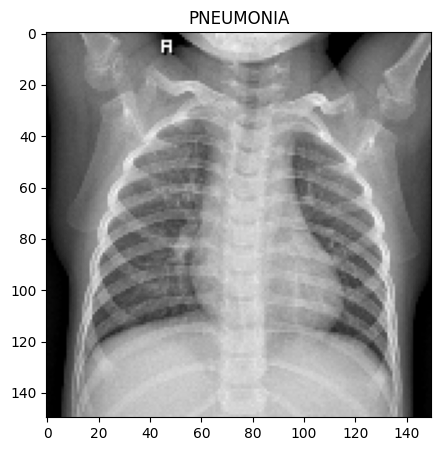

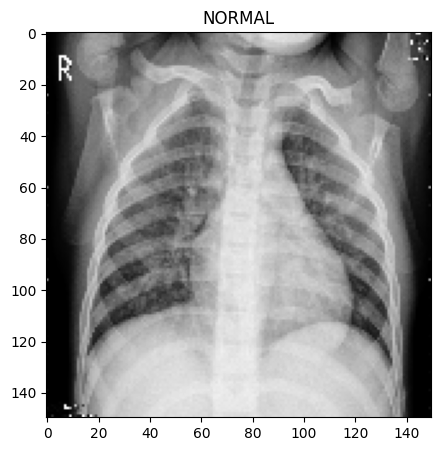

In [4]:
# Pneumonia Sample
plt.figure(figsize = (5,5))
plt.imshow(train[2][0], cmap='gray')
plt.title(labels[train[2][1]])

# Normal Sample
plt.figure(figsize = (5,5))
plt.imshow(train[3321][0], cmap='gray')
plt.title(labels[train[3321][1]])
plt.show()

* idk what is the diffrent in lung its quite the same 

### Split Data 

In [5]:
# Train
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


# Validaiton 
x_val = []
y_val = []
   
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


# Test 
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

 

In [6]:
# Normalize the data
x_train = (np.array(x_train) / 255)
x_val = (np.array(x_val) / 255)
x_test = (np.array(x_test) / 255)

In [7]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size , 1 )

##### ok let create a simple model 

In [8]:
from tensorflow import keras 
class MCDropout(keras.layers.Dropout):
    def call(self , inputs):
        return super().call(inputs , training = True )

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten
from tensorflow.keras import regularizers , constraints 

simpleModel = Sequential()
simpleModel.add(Conv2D(32 , kernel_size = (3,3),  strides = 1  , padding = 'same' , activation = 'linear' , input_shape = (150,150,1)))
simpleModel.add(MaxPool2D((2,2)))


simpleModel.add(Conv2D(64 , (3,3), activation = 'relu' , kernel_regularizer = regularizers.l2(l2 = 0.01)))
simpleModel.add(MaxPool2D(pool_size = (2,2)))


simpleModel.add(Conv2D(128 , (3,3) , activation = 'relu' , kernel_regularizer = regularizers.l2(l2 = 0.01)))
simpleModel.add(MaxPool2D(pool_size = (2,2)))

simpleModel.add(Flatten())

simpleModel.add(Dense(units = 512 , activation = 'relu' , kernel_initializer = "glorot_uniform" , kernel_regularizer = regularizers.l2(l2 = 0.01)))
simpleModel.add(MCDropout(0.5))

simpleModel.add(Dense(1 ,  activation = 'sigmoid' , kernel_initializer = "glorot_uniform" )) 
simpleModel.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


/home/aboud/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
simpleModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,033,601 (72.61 MB)

 Trainable params: 19,033,601 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras import optimizers , losses 
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping()

simpleModel.compile(
    loss = "binary_crossentropy",
    optimizer = optimizers.Adam(learning_rate = 0.0003),
    metrics =['accuracy']
) 
history = simpleModel.fit(x_train, y_train , epochs = 5 , batch_size = 32, validation_data = (x_val , y_val), shuffle=True )

Epoch 1/5


2024-07-20 14:49:46.383769: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 469440000 exceeds 10% of free system memory.


163/163 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.7630 - loss: 4.1972 - val_accuracy: 0.8125 - val_loss: 1.0739
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9262 - loss: 0.5950 - val_accuracy: 0.7500 - val_loss: 0.9346
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9425 - loss: 0.4478 - val_accuracy: 0.8125 - val_loss: 0.6688
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9395 - loss: 0.3987 - val_accuracy: 0.7500 - val_loss: 0.6777
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9520 - loss: 0.3437 - val_accuracy: 0.8125 - val_loss: 0.6360


In [12]:
y_pred = simpleModel.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step


### Evaluate the model 

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 

In [14]:
cr = classification_report(y_test,np.round(y_pred))
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.56      0.70       234
           1       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.78       624
weighted avg       0.84      0.82      0.81       624



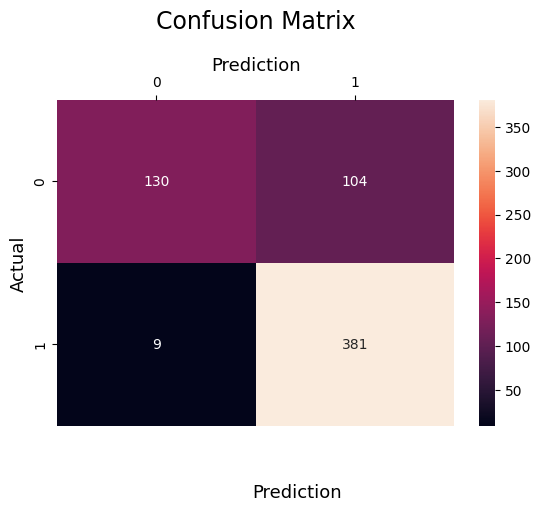

In [15]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()
